# Support Vector Machines

Welcome to your next lab! You will build SVM algorithm and explore working of this model with different kernels.


**You will learn to:**
- Build the general architecture of a learning algorithm with OOP in mind:
    - Helper functions:
        - Kernels
        - Kernels matrix
        - Computing lagrange multipliers
        - Extracting support features
        
    - Main Model Class:
        - Training
        - Prediction 

## 0 - Before the start ##

SVM is a rather complex method compared to the ones we learned before. For better understanding of the steps in lab we strongly recommend you to get through this topics (links to related guides):

- [Lagrangian](https://www.youtube.com/watch?v=BSKtQcLQLWU&list=PLCg2-CTYVrQvNGLbd-FN70UxWZSeKP4wV&index=3&ab_channel=KhanAcademy)
- [SVM algorithm and kernels intuition](https://www.youtube.com/watch?v=_PwhiWxHK8o&ab_channel=MITOpenCourseWare)
- [Quadratic optimization problem](https://www.youtube.com/watch?v=GZb9647X8sg&ab_channel=KodyPowell)
- [Using of cvxopt](https://www.youtube.com/watch?v=_EgoDT7RHwE&ab_channel=AhmadBazzi)
- [cvxopt tutorial](https://cvxopt.org/examples/tutorial/qp.html)

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [cvxopt](http://cvxopt.org) is a software package for convex optimization.

In [1353]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

cvxopt.solvers.options['show_progress'] = False

## 2 - Overview of the Dataset  ##

**Problem Statement**: You are given a dataset  containing:
    - a training set of m_train examples
    - a test set of m_test examples
    - each example is of shape (number of features, 1)
    
  This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

In [1354]:
def load_data():
    from sklearn.model_selection import train_test_split
    
    X = np.genfromtxt('mush_features.csv')
    Y = np.genfromtxt('mush_labels.csv')
    
    train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(X, Y, test_size=0.33, random_state=42)
    
    train_set_x = train_set_x[:300].astype(float)
    train_set_y = train_set_y[:300].astype(float)
    
    test_set_x = test_set_x[:100].astype(float)
    test_set_y = test_set_y[:100].astype(float)
    
    x_test = train_set_x[:5]
    y_test = train_set_y[:5]   
    
    train_set_x = train_set_x.reshape(train_set_x.shape[0], -1).T
    test_set_x = test_set_x.reshape(test_set_x.shape[0], -1).T
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    x_test = x_test.reshape(x_test.shape[0], -1).T
    y_test = y_test.reshape((1, y_test.shape[0]))
    
    return train_set_x, test_set_x, train_set_y, test_set_y, x_test, y_test

Many software bugs in machine learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

So, let's check shapes:

In [1355]:
train_set_x, test_set_x, train_set_y, test_set_y, x_test, y_test = load_data()
print('train_set_x.shape: ', train_set_x.shape)
print('test_set_x.shape: ', test_set_x.shape)
print('train_set_y.shape: ', train_set_y.shape)
print('test_set_y.shape: ', test_set_y.shape)

train_set_x.shape:  (22, 300)
test_set_x.shape:  (22, 100)
train_set_y.shape:  (1, 300)
test_set_y.shape:  (1, 100)


**Expected Output for m_train, m_test**: 
<table style="width:30%">
  <tr>
      <td><b>train_set_x.shape:</b></td>
    <td> (22, 300) </td> 
  </tr>
  
  <tr>
    <td><b>test_set_x.shape:</b></td>
    <td> (22, 100) </td> 
  </tr>
  
  <tr>
    <td><b>train_set_y.shape:</b></td>
    <td> (1,300) </td> 
  </tr>
  
  <tr>
    <td><b>test_set_y.shape:</b></td>
    <td> (1,100) </td> 
  </tr>
  

  
</table>

Distribution of samples in train set:

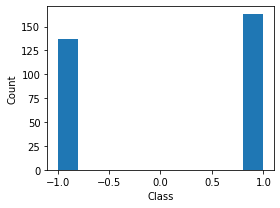

In [1356]:
plt.figure(figsize=(4, 3))
plt.hist(train_set_y.T)
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Distribution of samples in test set:

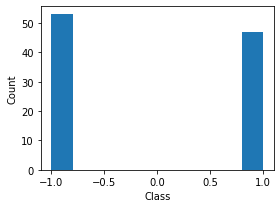

In [1357]:
plt.figure(figsize=(4, 3))
plt.hist(test_set_y.T)
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 3 - General Architecture of the learning algorithm ##

The SVM algorithm is implemented in practice using a kernel.

The learning of the hyperplane in linear SVM is done by transforming the problem using some linear algebra.

A powerful insight is that the linear SVM can be rephrased using the inner product of any two given observations, rather than the observations themselves. The inner product between two vectors is the sum of the multiplication of each pair of input values.

For example, the inner product of the vectors [2, 3] and [5, 6] is 28.

The equation for making a prediction for a new input using the dot product between the input ($x$) and each support vector ($x_s$) is calculated as follows: $$f(x) = sign(b + \sum_{s \in S}(\bar{w}_s* k(x, x_s)))$$

This is an equation that involves calculating the inner products of a new input vector ($x$) with all support vectors in training data. The coefficients $b$ and $\bar{w}_s$ (for each input) must be estimated from the training data by the learning algorithm. $S$ is a set of all support vectors and $k()$ is a kernel.

### 3.1 - Kernels ###




#### Linear Kernel

The dot-product is called the linear kernel and can be re-written as:

$$k(x_{i},x _{j}) = x_{i}x_{j}\tag{1}$$

Kernel is the function, that defines the similarity or a distance measure between new data and the support vectors. The dot product is the similarity measure used for linear SVM or a linear kernel because the distance is a linear combination of the inputs.

It is desirable to use more complex kernels as it allows lines to separate the classes that are curved or even more complex. This in turn can lead to more accurate classifiers.

#### Polynomial Kernel SVM ####
Instead of the dot-product, we can use a polynomial kernel, for example:

$$k(x_{i},x _{j}) = (x_{i}x_{j} + coef)^{d}\tag{2}$$

Where the degree of the polynomial must be specified additionally to the learning algorithm. When d=1 this is the same as the linear kernel. The polynomial kernel allows for curved lines in the input space.

#### Gaussian radial basis function (RBF) ####
$$k(x_{i}, x_{j})=exp(-\gamma {\left \| x_i-x_j \right \|^2})\tag{4}$$

Implement these kernel functions in the cell below:

In [1358]:
# GRADED CLASS: Kernel

class Kernel(object):
    def linear():
        """
            Returns:
            function that takes two vectors as a parameters and returns their dot product
        """
        ### START CODE HERE ###
        return lambda x, y: (x.T).dot(y)
        ### END CODE HERE ###
        
    def polynomial(coef, power):
        """
            Arguments:
            coef: float
            power: int
        
            Returns:
            function that takes two vectors as a parameters and computes polynomial kernel
        """
        ### START CODE HERE ### (≈ 1 line of code)
        return lambda x, y: ((x.T).dot(y) + coef)**power
        ### END CODE HERE ###
        
        
    def rbf(gamma):
        """
            Arguments:
            gamma: float
        
            Returns:
            function that takes two vectors as a parameters and computes rbf kernel
        """
        ### START CODE HERE ### (≈ 1-2 line of code)
        return lambda x, y: np.exp(((x-y)**2).sum()*(-gamma))
        ### END CODE HERE ###

In [1359]:
lin = Kernel.linear()
polynom = Kernel.polynomial(3, 2)
rbf = Kernel.rbf(0.0002)

xt = x_test[:, 1]
yt = x_test[:, 2]
print('linear_kernel: ', lin(xt, yt))
print('polynomial_kernel: ', polynom(xt, yt))
print('rbf_kernel: ', rbf(xt, yt))

linear_kernel:  202.0
polynomial_kernel:  42025.0
rbf_kernel:  0.9906440418940348


**Expected Output**: 
<table style="width:40%">
  <tr>
      <td><b>linear_kernel:</b></td>
    <td> 202.0 </td> 
  </tr>
  
  <tr>
    <td><b>polynomial_kernel:</b></td>
    <td>42025.0 </td> 
  </tr>
  
  <tr>
    <td><b>rbf_kernel:</b></td>
    <td> 0.9906440418940348 </td> 
  </tr>

  

  
</table>

### 3.2 SVM Algorithm
For more deteiled description you may check [this](http://www.math.utep.edu/Faculty/xzeng/2019fall_cps5401/2019fall_cps5401/CPS_5401_Introduction_to_Computational_Sciences_files/CPS5401_SVM.pdf) and [this](https://xavierbourretsicotte.github.io/SVM_implementation.html) articles. Note that designations may vary

The lagrangian of our function looks like:

$$L = \sum_{i}(\lambda) - \frac{1}{2} \sum_{i}\sum_{j}(\lambda_i*\lambda_j*y_i*y_j*k(x_i, x_j))$$

Where $\lambda$ - is lagrange multiplier,

$y$ - `train_set_y`,

$x$ - `train_set_x`,

$k()$ - kernel function

Maximizing this expression, we will get $\lambda$ for all the samples. If $\lambda = 0$ for some samples, this means, that these samples lie deep in it's class, so they can't be support vectors. The set of samples, that can be support vectors will be calles $S$

The main dificult in maximization here, that sought variable $\lambda$ is in second power (means $\lambda_i*\lambda_j$). So, in this case, we need to use quadratic optimization.

Standart form of quadratic optimization problem is:

$$\min(\frac{1}{2}x^T \times P \times x + q^T \times x)$$
$$s.t.$$
$$G \times x \leq h$$
$$A \times x = b$$
Where sought variable is $x$

In our case:

$$L = \sum_{i}(\lambda) - \frac{1}{2} \sum_{i}\sum_{j}(\lambda_i*\lambda_j*y_i*y_j*k(x_i, x_j))$$$$s.t.$$
$$\lambda_i \geq 0$$
$$\sum_{i}(\lambda_i*y_i) = 0$$

Can be represented in as:

$$L = (1,1, ... 1)^T \times \lambda - \frac{1}{2} \lambda^T \times y^T \times y \times K \times \lambda$$
$$s.t.$$
$$-\lambda \leq 0$$
$$y * \lambda = 0$$

Where $K$ - is kernel matrix of $X$ (train samples) and $\lambda$ is sought variable

And maximizing of expression above is the same as minimizing of:

$$min( \frac{1}{2} \lambda^T \times y^T \times y \times K \times \lambda - (1,1, ... 1)^T \times \lambda)$$
$$s.t.$$
$$-\lambda \leq 0$$
$$y * \lambda = 0$$

And now it's looks like standart form of quadratic optimization problem.

You just have to define P, q, G, h, A, b and then solve it with `cvxopt.solvers.qp`

After getting $\lambda$ we can replace $\bar{w}_s$ in our prediction function with:
$$\bar{w}_s = \sum_{s \in S}(\lambda_s * y_s)$$

And for making predictions use:
$$f(x) = sign(b + \sum_{s \in S}(\lambda_s * y_s*k(x, x_s)))$$

### 3.3 Model

In the main class you need to implement all the funcionallity:
1. `_kernel_matrix` - calculate kernel matrix
    - Get number of samples
    - Create zero matrix of quadratic shape of number of samples
    - Calculate kernels
2. `_compute_lagrange_multipliers` - solve a quadratic optimization problem and compute lagrange multipliers
    - Get number of samples
    - Create Kernel matrix by calling `_kernel_matrix` function
    - Create create quadratic term P based on Kernel matrix
    - Create linear term q
    - Create G, h, A, b
    - Solve with - cvxopt.solvers.qp(P, q, G, h, A, b)
    - Return flatten vector of lagrange multipliers
3. `_get_support_vectors` - extract support vectors
    - Get non-zero lagrange multipliers indicies
    - Get he corresponding lagrange multipliers
    - Get support vecorts
    - Get the samples that will act as support vectors
    - Get the corresponding labels
4. `fit` - compute b and lagrange multipliers
    - Solve a quadratic optimization problem and compute lagrange multipliers by calling `_compute_lagrange_multipliers`
    - Extract support vectors and non zero lagrange multipliers by calling `_get_support_vectors`
    - Calculate $b$ using first support vector: $b = y_{s0} - \sum_{s \in S} \lambda_s * y_s * k(x_{s0}, x_s)$, where $S$ is a set of all support vectors
5. `predict` - use trained by `fit` params to make predictions: $f(x) = sign(b + \sum_{s \in S}(\lambda_s * y_s*k(x, x_s)))$

In [1339]:
#GRADED CLASS: SVM

class SVM(object):
    """
    The Support Vector Machines classifier
    
    Arguments:
    C -- penalty term  
    kernel -- kernel function e.g. lambda x, y: ...
    """
    def __init__(self, C=1, kernel=Kernel.linear()):
        self.C = C
        self.kernel = kernel
        self.non_zero_multipliers = None
        self.support_vectors = None
        self.support_labels = None
        self.b = None
    
    def _kernel_matrix(self, X):
        """
        Computes kernel matrix applying kernel function pairwise for each sample

        Arguments:
        X -- input matrix of shape (number of features, number of samples)
        
        Returns:
        kernels matrix of shape (number of samples, number of samples)
        """
        ### START CODE HERE ###
        # Get number of samples
        n_samples = X.shape[1]
        
        # Calculate kernels pairwise and fill kernels matrix
        K = np.array([self.kernel(X[:, i], X[:, j]) for i in range(n_samples) for j in range(n_samples)]).reshape(n_samples, n_samples)
        # Return kernel matrix
        return K
        ### END CODE HERE ###

    def _compute_lagrange_multipliers(self, X, Y):
        """
        Solves the quadratic optimization problem and calculates lagrange multipliers

        Arguments:
        X -- input matrix of shape (number of features, number of samples)
        Y -- labels of shape (1, number of samples)

        Returns:
        numpy array of lagrange multipliers
        """
        ### START CODE HERE ###
        # Get number of samples
        n_samples = X.shape[1]
        
        # Get Kernel matrix by calling _kernel_matrix function
        # To create a matrix use cvxopt.matrix
        K = cvxopt.matrix(self._kernel_matrix(X))

        # Create create quadratic term P based on Kernel matrix
        # To create a matrix use cvxopt.matrix
        P = cvxopt.matrix(Y*np.transpose(Y)*K)
        
        # Create linear term q
        # To create a matrix use cvxopt.matrix
        q = cvxopt.matrix(-np.ones((n_samples,1)))

        # Create G, h
        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            
            h = cvxopt.matrix(np.vstack((h_max, h_min)))
        
        # Create A, b
        # To create a matrix use cvxopt.matrix
        A = cvxopt.matrix(Y.reshape(1,n_samples))
        b = cvxopt.matrix(0.0)

        # Solve the quadratic optimization problem using cvxopt
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        # Extract flat array of lagrange multipliers
        lagrange_multipliers = np.ravel(solution['x'])

        # Return lagrange multipliers
        return lagrange_multipliers
        ### END CODE HERE ###
    

    def _get_support_vectors(self, lagrange_multipliers, X, Y):
        """
        Extracts the samples that will act as support vectors and corresponding labels

        Arguments:
        lagrange_multipliers -- numpy array of lagrange multipliers
        X -- input matrix of shape (number of features, number of samples)
        Y -- labels of shape (1, number of samples)

        Returns:
        non_zero_multipliers -- numpy array of non-zero lagrange multipiers (>1e-7)
        support_vectors -- matrix of support vectors of shape (number of features, number of support vectors)
        support_vector_labels -- corresponding labels of shape (1, number of support vectors)
        """
        ### START CODE HERE ###
        # Get indexes of non-zero lagrange multipiers
        idx = lagrange_multipliers > 1e-7
        
        # Get the corresponding lagrange multipliers
        non_zero_multipliers = lagrange_multipliers[idx]
        
        # Get the samples that will act as support vectors
        support_vectors = X[:,idx]
        # Get the corresponding labels
        support_labels = Y[:,idx]
 
        # Return 
        return non_zero_multipliers, support_vectors, support_labels
        ### END CODE HERE ###

    def fit(self, X, Y):
        """
        Main training function

        Arguments:
        X -- input matrix of shape (number of features, number of samples)
        Y -- labels of shape (1, number of samples)
        """
        ### START CODE HERE ###
        # Solve the quadratic optimization problem and get lagrange multipliers
        n_samples = X.shape[1]
        lagrange_multipliers = self._compute_lagrange_multipliers(X, Y)
        # Extract support vectors and non zero lagrange multipliers
        self.non_zero_multipliers, self.support_vectors, self.support_labels = self._get_support_vectors(lagrange_multipliers, X, Y) 
        # Calculate b using first support vector
        self.b = self.support_labels[0][0] - sum([alpha * y * self.kernel(self.support_vectors[:,0], x) 
                                                       for (alpha, y, x) in zip(self.non_zero_multipliers, self.support_labels.T, self.support_vectors.T)])
        ### END CODE HERE ###
        
    def predict(self, X):
        """
        Predict function

        Arguments:
        X -- input matrix of shape (number of features, number of samples)
        
        Returns:
        predictions of shape (1, number of samples)
        """
        ### START CODE HERE ###
        n_samples = X.shape[1]
        
        values = []
        for x in X.T:
            values.append(self.b + sum([alpha*y*self.kernel(x, xs) for(alpha, y, xs) in zip(self.non_zero_multipliers, self.support_labels.T, self.support_vectors.T)]))

        predictions = np.sign(values).reshape(1, -1)
        return predictions
        ### END CODE HERE ###

Initialize model with default linear term and penalty term = 2

In [1340]:
model = SVM(C=2)

Kernel matrix check

In [1341]:
k = model._kernel_matrix(x_test)
print('kernel matrix:')
print(k)

kernel matrix:
[[240. 231. 190. 145. 180.]
 [231. 248. 202. 152. 201.]
 [190. 202. 203. 135. 197.]
 [145. 152. 135. 109. 129.]
 [180. 201. 197. 129. 255.]]


**Expected Output**: 
<table style="width:35%">
  <tr>
      <td style="width:15%"><b>kernel matrix:</b></td>
    <td> [[ 240.  231.  190.  145.  180.]<br>
 [ 231.  248.  202.  152.  201.]<br>
 [ 190.  202.  203.  135.  197.]<br>
 [ 145.  152.  135.  109.  129.]<br>
 [ 180.  201.  197.  129.  255.]]
      </td> 
  </tr>
  
  
</table>

Lagrange multipliers check

In [1342]:
lm = model._compute_lagrange_multipliers(x_test, y_test)
print('lagrange multipliers: ')
print(lm)

lagrange multipliers: 
[0.00540158 0.02154727 0.06545855 0.05981161 0.03259579]


**Expected Output**: 
<table style="width:30%">
  <tr style="width:10%">
      <td><b>lagrange multipliers:</b></td>
    <td> [0.00540158<br>0.02154727<br>0.06545855<br>0.05981161<br>0.03259579]
      </td> 
  </tr>
  
  
</table>

Support vector extraction check, remember that support vectors are columns

In [1343]:
nzl, sv, sl = model._get_support_vectors(lm, x_test,y_test)
print('non-zero lagrange multipliers:')
print(nzl)
print('support vectors:')
print(sv)
print('support labels:')
print(sl)

non-zero lagrange multipliers:
[0.00540158 0.02154727 0.06545855 0.05981161 0.03259579]
support vectors:
[[5. 5. 2. 2. 2.]
 [3. 3. 2. 0. 3.]
 [4. 2. 4. 3. 2.]
 [1. 1. 0. 0. 0.]
 [5. 5. 5. 2. 7.]
 [1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [7. 5. 4. 3. 0.]
 [1. 1. 1. 0. 1.]
 [1. 1. 3. 1. 0.]
 [2. 2. 2. 1. 1.]
 [2. 2. 0. 1. 1.]
 [7. 7. 7. 6. 7.]
 [3. 7. 7. 4. 7.]
 [0. 0. 0. 0. 0.]
 [2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1.]
 [4. 4. 0. 2. 0.]
 [3. 2. 3. 1. 7.]
 [4. 5. 3. 4. 4.]
 [0. 0. 1. 1. 4.]]
support labels:
[[-1. -1. -1.  1.  1.]]


**Expected Output for m_train, m_test**: 
<table style="width:50%">
    <tr>
    <td><b>non-zero lagrange multipliers:</b></td>
    <td> [ 0.00540158<br>  0.02154727<br>  0.06545855<br>  0.05981161<br>  0.03259579]
      </td> 
  </tr>
  <tr>
      <td><b>support vectors:</b></td>
    <td> [[5. 5. 2. 2. 2.]<br>
 [3. 3. 2. 0. 3.]<br>
 [4. 2. 4. 3. 2.]<br>
 [1. 1. 0. 0. 0.]<br>
 [5. 5. 5. 2. 7.]<br>
 [1. 1. 1. 1. 1.]<br>
 [0. 0. 1. 0. 0.]<br>
 [0. 0. 0. 0. 1.]<br>
 [7. 5. 4. 3. 0.]<br>
 [1. 1. 1. 0. 1.]<br>
 [1. 1. 3. 1. 0.]<br>
 [2. 2. 2. 1. 1.]<br>
 [2. 2. 0. 1. 1.]<br>
 [7. 7. 7. 6. 7.]<br>
 [3. 7. 7. 4. 7.]<br>
 [0. 0. 0. 0. 0.]<br>
 [2. 2. 2. 2. 2.]<br>
 [1. 1. 1. 1. 1.]<br>
 [4. 4. 0. 2. 0.]<br>
 [3. 2. 3. 1. 7.]<br>
 [4. 5. 3. 4. 4.]<br>
 [0. 0. 1. 1. 4.]]
      </td> 
  </tr>
    <tr>
        <td><b>support labels:</b></td>
    <td> [[-1. -1. -1.  1.  1.]]
      </td> 
  </tr>

</table>

Definition of accuracy metrics for classification

In [1344]:
def accuracy(predictions, labels):
    return np.sum(predictions == labels, axis=1) / float(labels.shape[1])

## 4 - Training

Firstly, let's initialize our classifier:

In [1345]:
clf = SVM(C=1, kernel=Kernel.linear())

And, finaly, train

In [1346]:
clf.fit(train_set_x, train_set_y)

## 5 - Making predictions

In [1347]:
y_pred = clf.predict(test_set_x)

Let's calculate accuracy (accuracy of model must be >0.97):

In [1348]:
accuracy(y_pred, test_set_y)

array([0.99])

## 6 - Visualization

Now let's generate some simple data to see how types of kernel affects the decision boundary.

In [1349]:
samples = np.random.normal(size=200).reshape(2, 100)
labels = (2 * (samples.sum(axis=0) > 0) - 1.0).reshape(1, 100)

In [1350]:
def plot(model, X, Y, grid_size):
    import matplotlib.cm as cm
    import itertools
    
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
        indexing='ij'
    )
    
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []

    model.fit(X, Y)
    
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([[xx[i, j]], [yy[i, j]]])
        result.append(model.predict(point)[0, 0])

    print(np.array(result).shape)
    print(xx.shape)
    
    Z = np.array(result).reshape(xx.shape)
    
    plt.contourf(
        xx, yy, Z,
        cmap=cm.Paired,
        levels=[-0.01, 0.01],
        extend='both',
        alpha=0.7
    )
    
    
    plt.scatter(
        flatten(X[0, :]),
        flatten(X[1, :]),
        c=flatten(Y),
        cmap=cm.Paired,
    )
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

#### Linear Kernel

(40000,)
(200, 200)


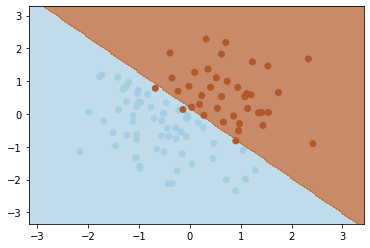

In [1351]:
clf_lin = SVM(C=1, kernel=Kernel.linear())
plot(clf_lin, samples, labels, 200)

#### Polynomial Kernel

(40000,)
(200, 200)


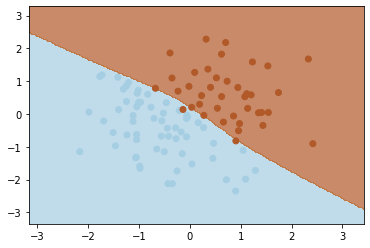

In [1352]:
clf_polynomial = SVM(C=1, kernel=Kernel.polynomial(1, 3))
plot(clf_polynomial, samples, labels, 200)

#### RBF

(40000,)
(200, 200)


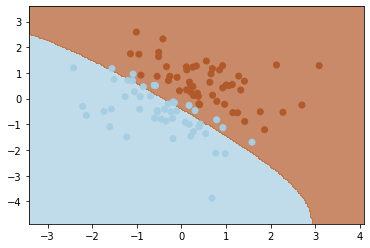

In [1331]:
clf_rbf = SVM(C=1, kernel=Kernel.rbf(0.03))
plot(clf_rbf, samples, labels, 200)

## 7 - Conclusion
As we can see, our model fits well the hypothesis function to the data.

#### What's next:
1. Try experimenting with the kernel parameters to see how this affects the model you have built.
2. Compare the results you have obtained with the `sklearn.svm.SVC` model.
3. Try this model in the wild! Select your favorite dataset [here](https://www.kaggle.com/datasets?sortBy=hottest&group=public&page=1&pageSize=20&size=small&filetype=all&license=all&tagids=13303) and play with it.